# <center>Machine Learning Optimization</center>
# KAI RU
# Keio university
# ABSTRACT: Convex optimization like Mean Variance Optimization solutions tend to be unstable, to the point of entirely offsetting the benefits of optimization. For example, in the context of financial applications, it is known that portfolios optimized in-sample often underperform the naïve (equal weights) allocation out-of-sample. This instability can be traced back to two sources: (i) noise in the input variables; and (ii) signal structure that magnifies the estimation errors in the input variables. A first innovation of this paper is to introduce the nested clustered optimization algorithm (NCO), a method that tackles both sources of instability.
# Over the past 60 years, various approaches have been developed to address these two sources of instability. These approaches are flawed in the sense that different methods may be appropriate for different input variables, and it is unrealistic to expect that one method will dominate all the rest under all circumstances. Accordingly, a second innovation of this paper is to introduce MCOS, a Monte Carlo approach that estimates the allocation error produced by various optimization methods on a particular set of input variables. The result is a precise determination of what method is most robust to a particular case. Thus, rather than relying always on one particular approach, MCOS allows users to apply opportunistically whatever optimization method is best suited in a particular setting.
# We will compare all two tranditional methods of optimization, Black Litterman  as maximum returns of a portfolio and Mean Variance Optimization with Machine Learning Optimization Nested Clustered simulated value, Convex Optimization simulated value, Nested Clustered with MCOS simulated value and Convex Optimization Solution with MCOS in this paper by optimizing 92 stocks in US market.

# 1. The goal: Build a portfolio from the US stock market, simulate a three-month short-term investment, and evaluate the actual return by comparing the all 6 models. We use SP100 dataset which contain 92 stocks without missing data.The training period will be from June 16, 2010 to March 17, 2020. The simulation period is from March 18, 2020 to June 16, 2020. Set the brand to 20.As reference to highest Return and sharpe ratio, we introduce Black Litterman model as maximum future return model after three months comparing these to the performance of other portfolios.

## (1) As external information, it is first necessary to know the risk-free interest rate and market price. Measured using the 52 Week Treasury Bill as a risk-free interest rate.

In [1]:
#Simulation period
import datetime
datetime.datetime(2020, 3, 17)-datetime.datetime(2010, 6, 16)

datetime.timedelta(days=3562)

In [2]:
import datetime
datetime.datetime(2020, 6, 16)-datetime.datetime(2020, 3, 18)

datetime.timedelta(days=90)

In [3]:
3562/(52*7)

9.785714285714286

In [4]:
import quandl
quandl.ApiConfig.api_key = 'DxKMsvF36hXo5BAMpeDK'
Wk_Bank_Discount_Rate_52=quandl.get("USTREASURY/BILLRATES" ,
                          start_date=datetime.datetime(2010, 6, 16), 
                          end_date=datetime.datetime(2020, 3, 17))

In [5]:
#Downloading bond price
yield_list=[]
for i in range(10):
    yield_list.append(Wk_Bank_Discount_Rate_52[datetime.datetime(2010, 6, 16)+datetime.timedelta(days=364*i):]\
                      ["52 Wk Bank Discount Rate"][0])

In [6]:
yield_list

[0.28, 0.18, 0.17, 0.13, 0.1, 0.26, 0.58, 1.14, 2.24, 1.99]

## Simulation period Yield from October 1, 2012 to September 12, 2019 S = (1 + S0) x (1 + S1) x (1 + S2) x (1 + S3) x (1 + S4 ) x(1 + S5)x(1 + S6)x(1 + S7)x(1 + S8)x(1 + S9) -1

In [7]:
S=(1+yield_list[0]/100)*(1+yield_list[1]/100)*(1+yield_list[2]/100)*\
(1+yield_list[3]/100)*(1+yield_list[4]/100)*(1+yield_list[5]/100)*(1+yield_list[6]/100)\
*(1+yield_list[7]/100)*(1+yield_list[8]/100)*(1+yield_list[9]*(3562/((52*7)*10))/100)-1

In [8]:
S

0.07223607162892498

## If you invest $1 in the bond on June 16, 2010, you will have an asset of 1.072 on March 17, 2020. This is defined as a safe asset, and the interest rate of this safe asset is a risk-free interest rate.

In [9]:
risk_free=S

In [10]:
risk_free

0.07223607162892498

In [11]:
risk_free_annual=risk_free/9.785714285714286

In [12]:
risk_free_annual

0.007381788341641968

## Risk-free interest rate for simulation period

In [13]:
import quandl
quandl.ApiConfig.api_key = 'DxKMsvF36hXo5BAMpeDK'
Wk_Bank_Discount_Rate_8=quandl.get("USTREASURY/BILLRATES" ,
                          start_date=datetime.datetime(2020, 3, 18), 
                          end_date=datetime.datetime(2020, 6, 16))

In [14]:
#Downloading bond price
rate_free_simulation=Wk_Bank_Discount_Rate_8["8 Wk Bank Discount Rate"][0]/100
rate_free_simulation

0.0003

## (3) Download the selected stocks as Training Datasets

In [15]:
import pandas as pd
import numpy as np
data=pd.read_excel("S&P 100 constituents Aktienkurse-work.xlsx",encoding="SHIFT-JIS",header=3)
data=data.drop(labels=0)
data=data.reset_index(drop= True)
data.index=data["Name"]
data=data.drop(["Name"],axis=1)
data=data.dropna(axis=1)
symbols = data.columns
df = data[symbols]
df=df.astype("float")
data=df[datetime.datetime(2010, 6, 16):datetime.datetime(2020, 3, 17)]

In [16]:
data.head()

,AMAZON.COM,ABBOTT LABORATORIES,INTERNATIONAL BUS.MCHS.,ADOBE (NAS),ALLSTATE ORD SHS,HONEYWELL INTL.,AMGEN,AMERICAN EXPRESS,AMERICAN INTL.GP.,COMCAST A,...,ACCENTURE CLASS A,AMERICAN TOWER,DUKE ENERGY,MONDELEZ INTERNATIONAL CL.A,BOOKING HOLDINGS,RAYTHEON TECHNOLOGIES,MEDTRONIC,WALGREENS BOOTS ALLIANCE,ALPHABET A,CHARTER COMMS.CL.A
Name,,,,,,,,,,,,,,,,,,,,,
2010-06-16,126.900,23.3447,130.35,32.4400,30.22,40.6987,55.22,42.34,31.7271,9.195,...,38.69,44.70,49.56,19.4518,196.41,40.4554,39.12,29.24,250.8781,38.3764
2010-06-17,125.890,23.2682,130.98,33.1200,30.06,40.6034,55.44,42.06,31.6433,9.290,...,38.49,44.97,50.13,19.6153,195.26,40.4377,38.97,29.27,250.2825,38.4317
2010-06-18,125.830,23.3351,130.15,33.5200,30.54,40.8605,55.20,42.03,31.7606,9.255,...,38.93,45.07,49.92,19.6350,193.09,40.8034,38.87,30.09,250.2575,38.9847
2010-06-21,122.550,23.1103,130.65,33.1300,30.27,40.8700,56.52,42.60,32.4727,9.175,...,38.81,45.12,49.77,19.5892,189.25,40.9155,38.68,30.14,244.5169,38.9847
2010-06-22,122.307,22.9619,129.30,32.7625,30.55,40.1750,56.12,41.94,32.0622,9.120,...,38.24,44.37,48.96,19.2097,188.95,40.1015,38.08,28.17,243.3609,39.2612


## (4) Plot time series transition and rate of return

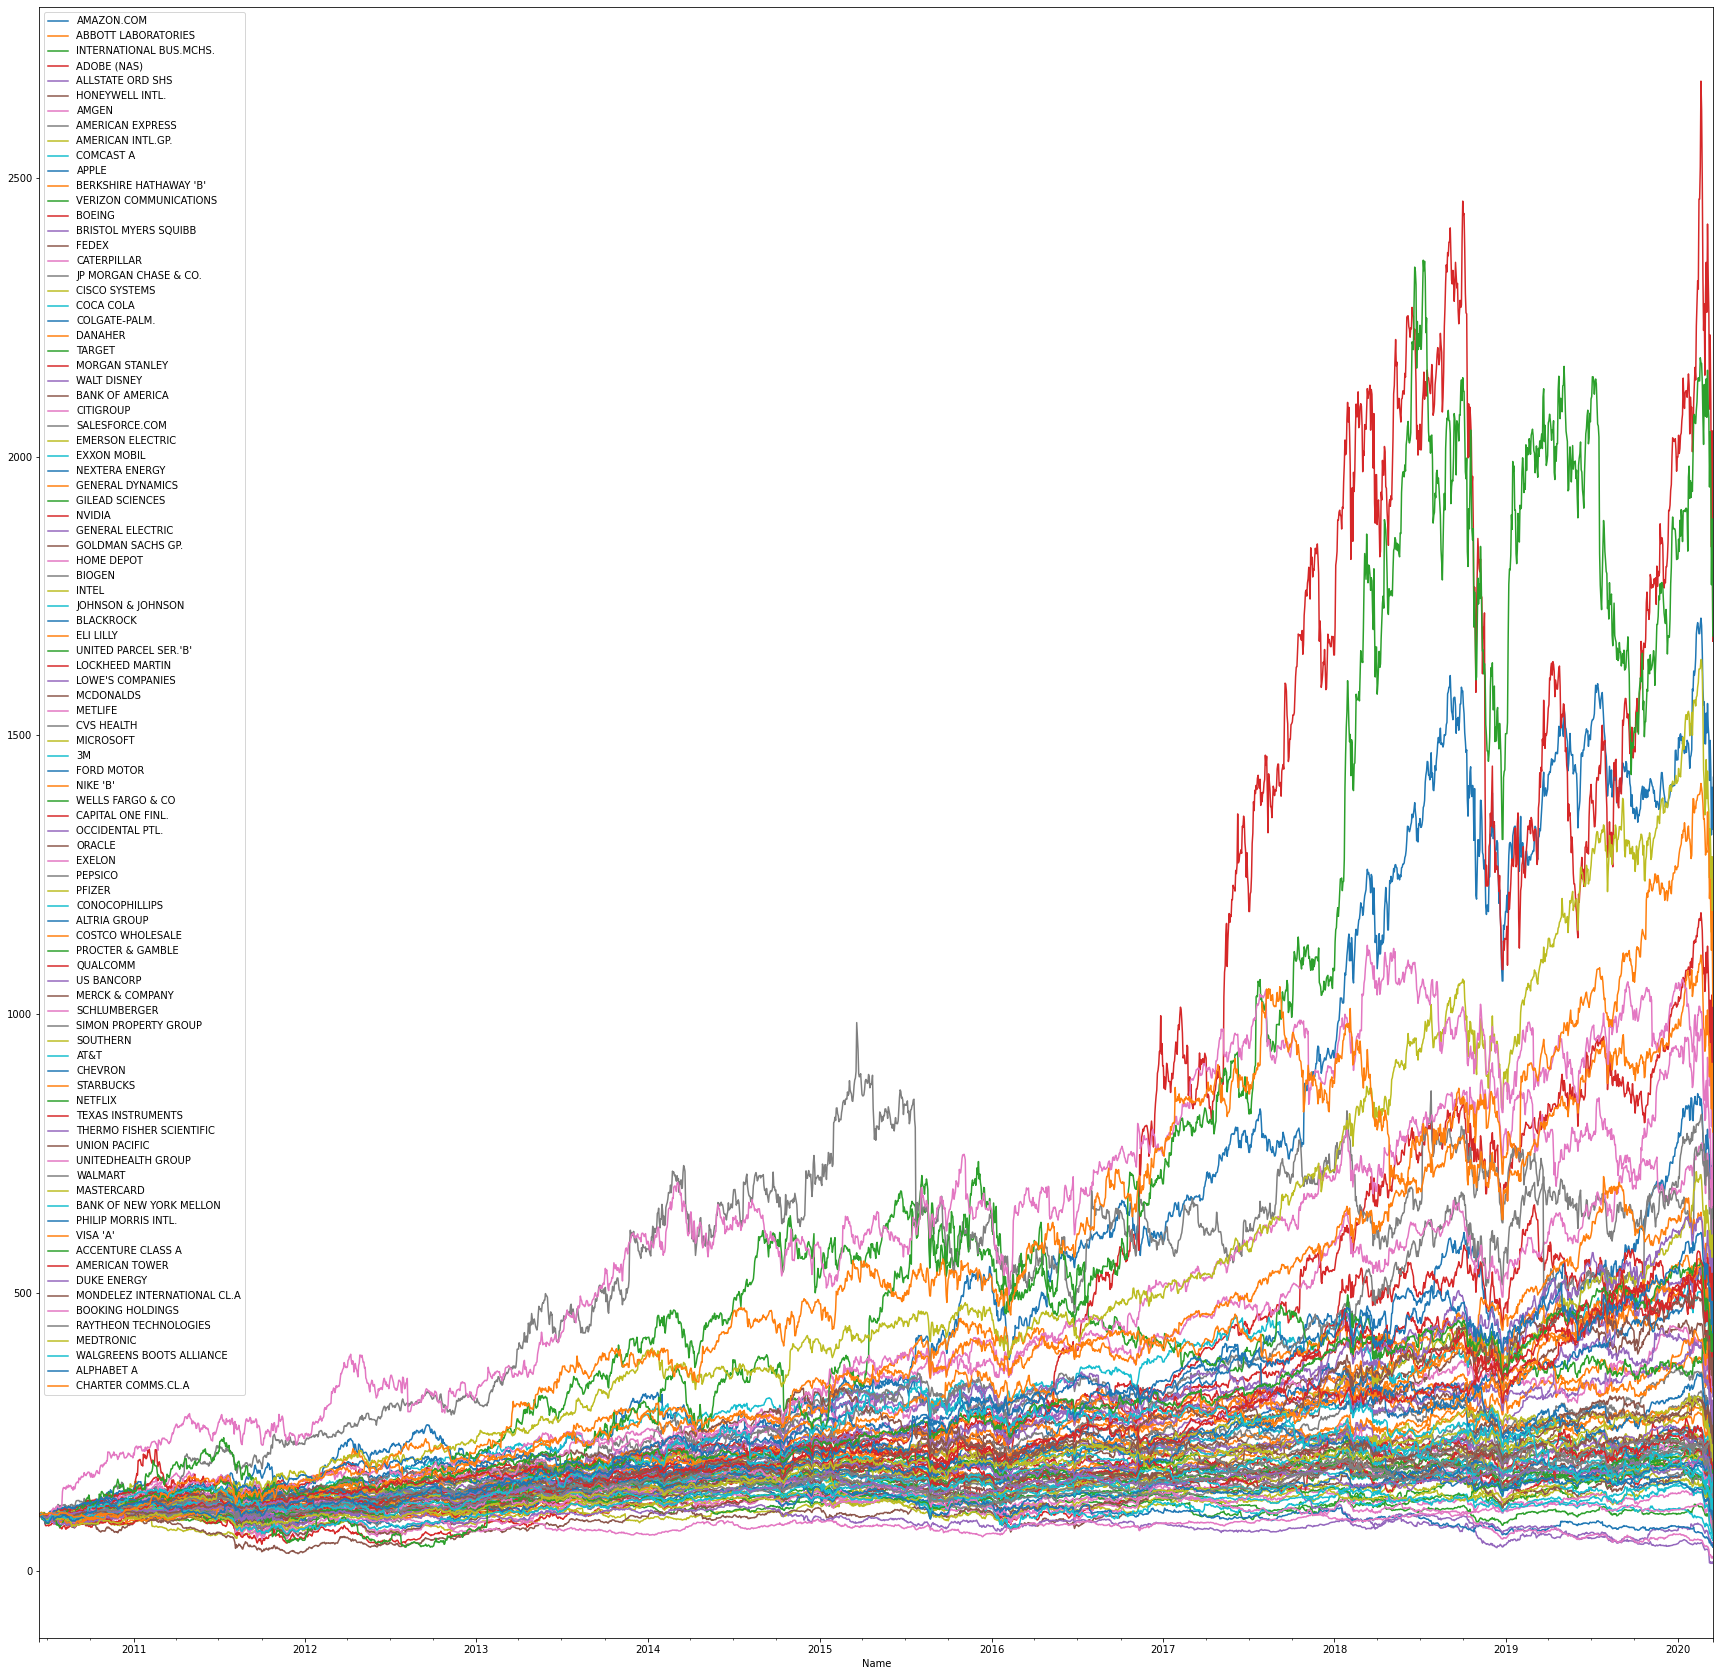

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
(data / data.iloc[0] * 100).plot(figsize=(30, 30))
plt.savefig('stat_01.png')

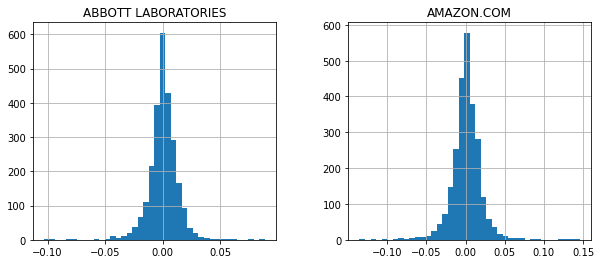

In [18]:
noa = len(symbols)
data = data[symbols]
rets = np.log(data / data.shift(1))
rets[symbols[:2]].hist(bins=40, figsize=(10, 4))
plt.savefig('stat_2.png')

# 2, mean variance model
## (1) Model optimization

In [19]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data,frequency=252)

#mean variance model optimization
EF_min = EfficientFrontier(mu, S)

EF_min.min_volatility()
#portfolio performance
EF_min.portfolio_performance(verbose=True)

Expected annual return: 8.8%
Annual volatility: 11.9%
Sharpe Ratio: 0.57


(0.08756070549588718, 0.11886679211421806, 0.5683732545837418)

In [20]:
#CAPM optimization
#Enter non-risky asset
EF = EfficientFrontier(mu, S)
weights = EF.max_sharpe(risk_free_rate=risk_free_annual)
#Portfolio ratio
EF.portfolio_performance(verbose=True)

Expected annual return: 24.8%
Annual volatility: 16.4%
Sharpe Ratio: 1.39


(0.24812788179446066, 0.1642919591019082, 1.3885517163560992)

In [21]:
#Weights in each stock
EF_clean_weights=EF.clean_weights()

## (2) Download the data of each stock from March 18, 2020 to June 16, 2020 will be collected for simulation.

In [22]:
import pandas as pd
import numpy as np
data2=pd.read_excel("S&P 100 constituents Aktienkurse-work.xlsx",encoding="SHIFT-JIS",header=3)
data2=data2.drop(labels=0)
data2=data2.reset_index(drop= True)
data2.index=data2["Name"]
data2=data2.drop(["Name"],axis=1)
data2=data2.dropna(axis=1)
symbols2 = data2.columns
df2 = data2[symbols]
df2=df2.astype("float")
data2=df2[datetime.datetime(2010, 3, 18):datetime.datetime(2020, 6, 16)]

## (3) If managed from March 18, 2020 to June 16, 2020, the average return of the portfolio will be
## R = 1r1 + w2r2 + ... + wn * rn
## ri = Return of individual stock
## wi = weight of individual stock
## R = average revenue of the portfolio

In [23]:
Mean_variance_return=np.sum(np.array(EF.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))
Mean_variance_return

0.2644077214185799

## (4) Volatility of the mean variance model portfolio

In [24]:
from pypfopt import objective_functions
Mean_variance_Volatility=np.sqrt(objective_functions.portfolio_variance(EF.weights, risk_models.sample_cov(data2)))
Mean_variance_Volatility

0.1721004625256966

# 3. Black – Litterman model

## (1) For the maxmize the Return of portfolio, calculate the actual return of each stock from March 18, 2020 to June 16, 2020

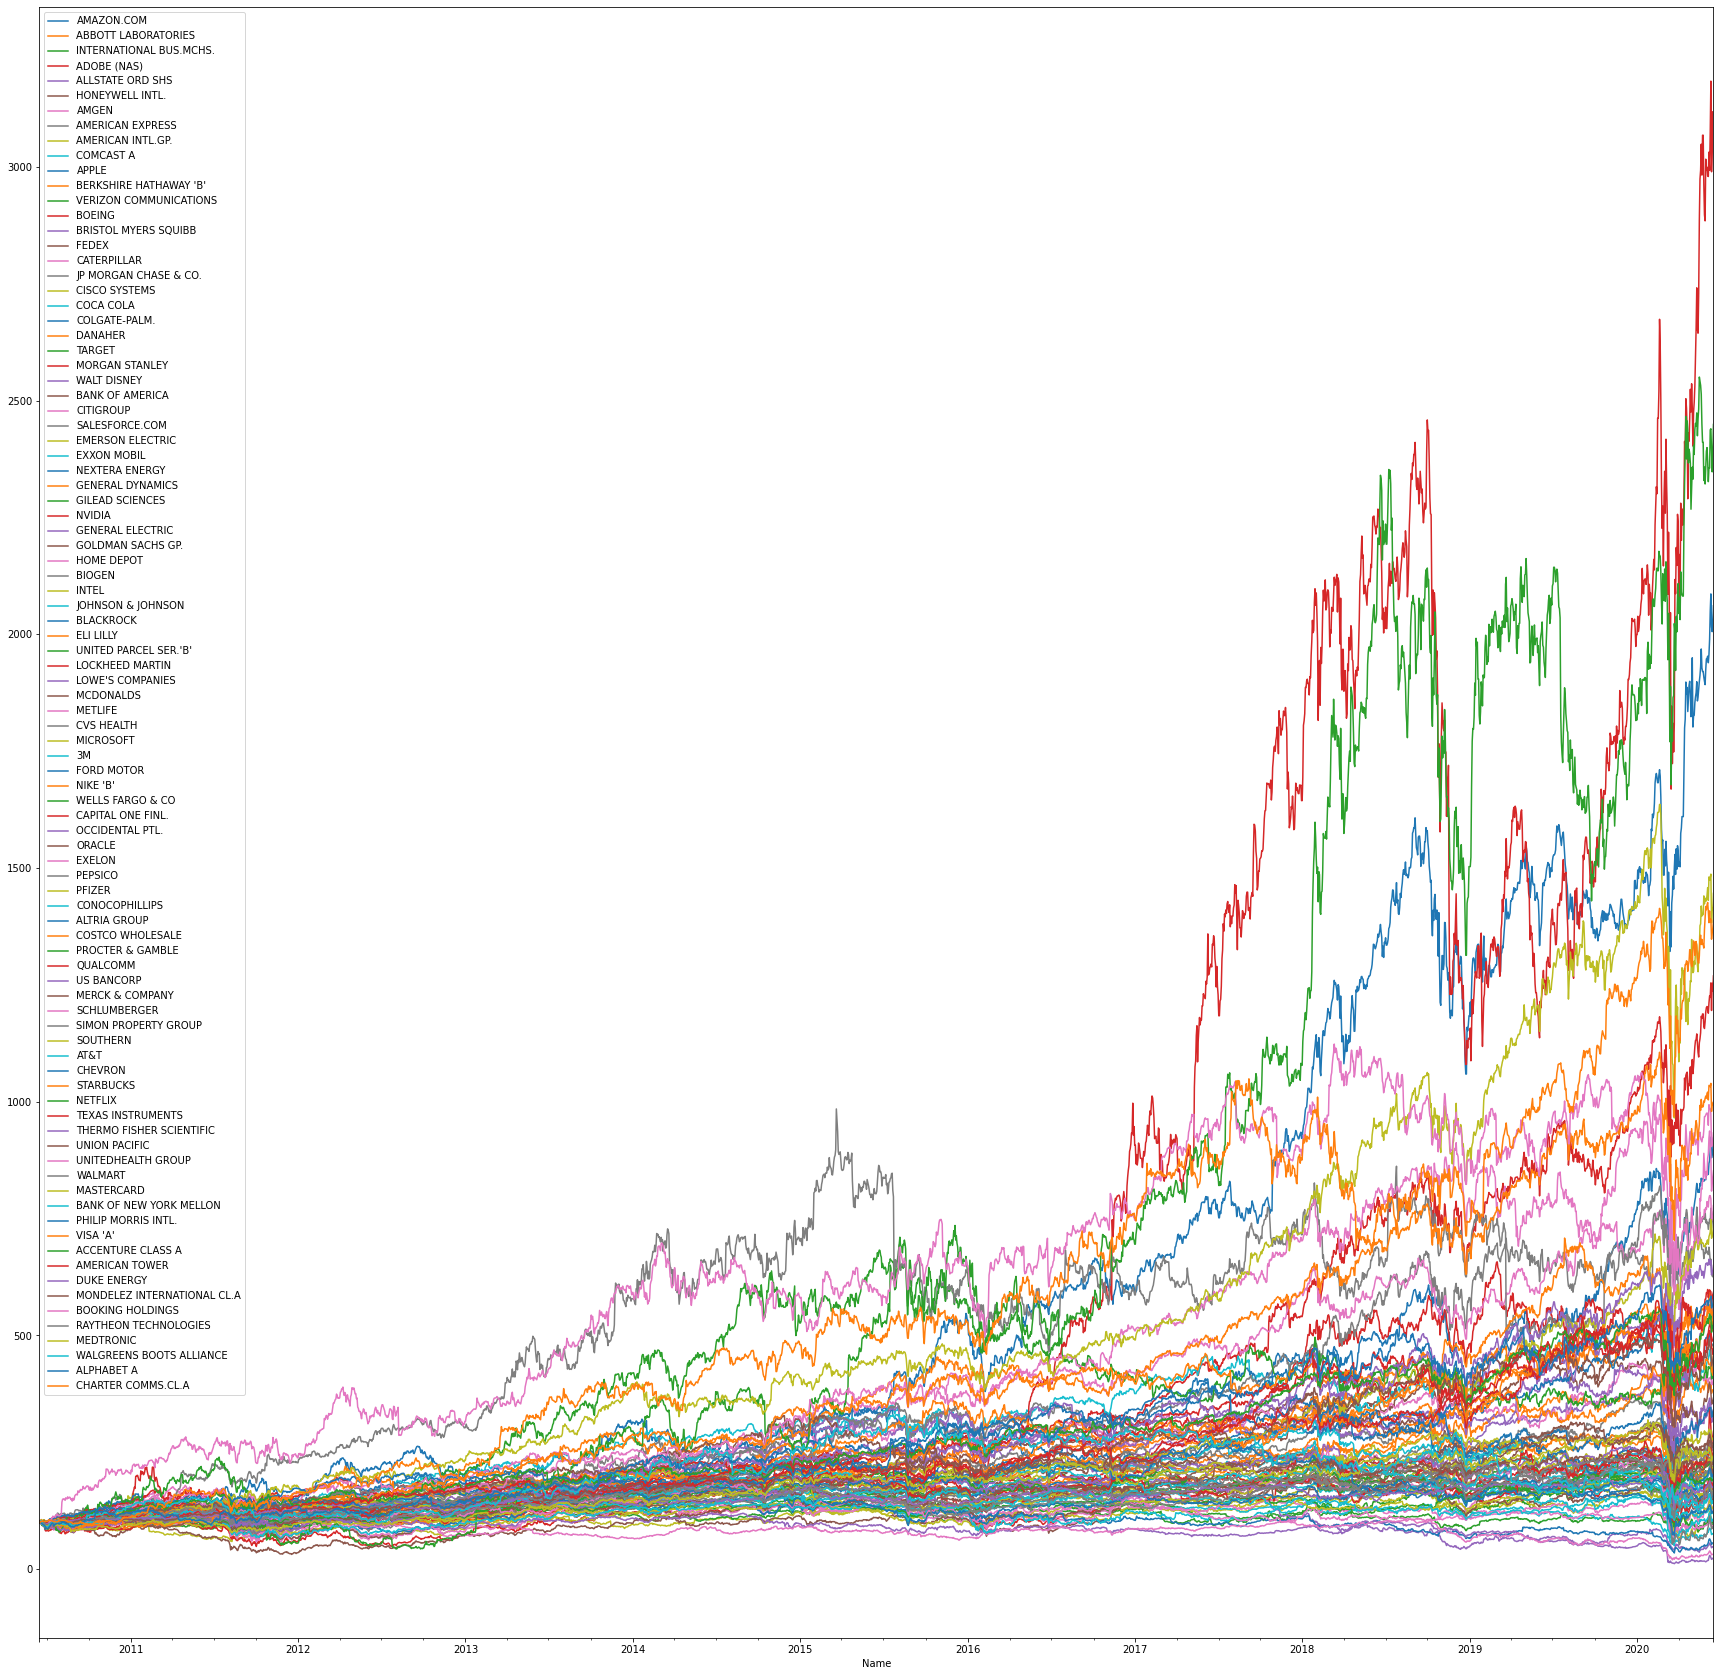

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
(data2 / data2.iloc[0] * 100).plot(figsize=(30, 30))
plt.savefig('stat_02.png')

In [26]:
expected_returns.mean_historical_return(data2, frequency=252)

AMAZON.COM                  0.339698
ABBOTT LABORATORIES         0.152135
INTERNATIONAL BUS.MCHS.     0.020373
ADOBE (NAS)                 0.289583
ALLSTATE ORD SHS            0.139550
                              ...   
RAYTHEON TECHNOLOGIES       0.079359
MEDTRONIC                   0.110709
WALGREENS BOOTS ALLIANCE    0.072114
ALPHABET A                  0.200967
CHARTER COMMS.CL.A          0.291872
Length: 92, dtype: float64

## (3) Setting critic reviews for each brand
## Referring to the above figures and data supposed that I could correctly predict the future returns after three months, exactly same as the actual returns above.

In [27]:
from pypfopt.black_litterman import BlackLittermanModel
S = risk_models.sample_cov(data)

viewdict = expected_returns.mean_historical_return(data2, frequency=252)

In [28]:
bl = BlackLittermanModel(S, absolute_views=viewdict)
rets = bl.bl_returns()

/usr/local/anaconda3/lib/python3.7/site-packages/pypfopt/black_litterman.py:252: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


## (4) Calculate the return of each brand

In [29]:
rets

AMAZON.COM                  0.269284
ABBOTT LABORATORIES         0.144312
INTERNATIONAL BUS.MCHS.     0.075999
ADOBE (NAS)                 0.249544
ALLSTATE ORD SHS            0.105785
                              ...   
RAYTHEON TECHNOLOGIES       0.108264
MEDTRONIC                   0.128790
WALGREENS BOOTS ALLIANCE    0.100092
ALPHABET A                  0.197564
CHARTER COMMS.CL.A          0.198858
Length: 92, dtype: float64

## (5) Introduce SP500 as market price

In [30]:
import pandas_datareader as pdr
SP500 = pdr.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2010, 6, 16), 
                          end=datetime.datetime(2020, 3, 17))

/usr/local/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [31]:
market_prices=SP500["Close"]

## (6) Black – Litterman model simulation

In [32]:
from pypfopt import black_litterman

delta = black_litterman.market_implied_risk_aversion(market_prices,risk_free_rate=risk_free_annual)

ef = EfficientFrontier(rets, S)

bl.bl_weights(delta)
weights = bl.clean_weights()

In [33]:
bl.portfolio_performance(verbose=True)

Expected annual return: 40.1%
Annual volatility: 24.9%
Sharpe Ratio: 1.53


(0.40112581180385554, 0.24902182924328256, 1.5304915756261417)

In [34]:
Black_Litterman_weights=weights

In [35]:
sum(weights.values())

1.00008

## (7) If managed from March 18, 2020 to June 16, 2020, the average return of the portfolio will be
## R = 1r1 + w2r2 + ... + wn * rn
## ri = Return of individual stock
## wi = weight of individual stock
## R = average revenue of the portfolio

In [36]:
BL_return=np.sum(np.array(bl.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [37]:
BL_return

0.6924012851036944

## (8) Portfolio volatility

In [38]:
from pypfopt import objective_functions
Black_Litterman_volatility=np.sqrt(objective_functions.portfolio_variance(bl.weights, risk_models.sample_cov(data2)))

In [39]:
Black_Litterman_volatility

0.27385893426963687

## 4. Machine Learning Optimization, Nested Clustered Optimization algorithm(NCO), Convex Optimization Solution(CVO) and Monte Carlo approach(MCOS)

## (1)Calculate the Return of Data

In [40]:
data_return=data.pct_change().fillna(0)

## (2)Optimization of NCO & CVO

In [41]:
import pandas as pd
from mlfinlab.portfolio_optimization import NCO
max_num_clusters = 91

# Import dataframe of returns for assets in a portfolio


# Calculate empirical covariance of assets
assets_cov = np.array(data_return.cov())

# Calculate empirical means of assets
assets_mean = np.array(data_return.mean()).reshape(-1, 1)

# Class that contains needed functions
nco = NCO()

# Find optimal weights using the NCO algorithm
w_nco = nco.allocate_nco(assets_cov, assets_mean,max_num_clusters)

# Find optimal weights using the CVO algorithm
w_cvo = nco.allocate_cvo(assets_cov, assets_mean)


In [42]:
nco_weights= w_nco/sum(w_nco)

## (3)Return of NCO method

In [43]:
NCO_return=np.sum((w_nco/sum(w_nco)).flatten()*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [44]:
NCO_return

0.9242727684129627

## (4)Return of CVO method

In [45]:
CVO_return=np.sum((w_cvo/sum(w_cvo)).flatten()*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [46]:
CVO_return

1.3304571405130425

## (5)Variance of NCO method

In [47]:
NCO_volatility=np.sqrt(objective_functions.portfolio_variance((w_nco/sum(w_nco)).flatten(), risk_models.sample_cov(data2)))

In [48]:
NCO_volatility

0.37340185335231696

## (6)Variance of CVO method

In [49]:
CVO_volatility=np.sqrt(objective_functions.portfolio_variance((w_cvo/sum(w_cvo)).flatten(), risk_models.sample_cov(data2)))

In [50]:
CVO_volatility

0.5079393517914165

## (7)Optimization of MCOS(Parameters are: 1 simulations, 2545 observations in a simulation)

In [157]:
# Compare the NCO solutions to the CVO ones using MCOS
# Parameters are: 10 simulations, 2545 observations in a simulation
# goal of maximum sharpe ratio, using LW shrinkage

w_cvo_mcos, w_nco_mcos = nco.allocate_mcos(assets_mean, assets_cov, 2545, 1, 0.01, False, False)

# Find the errors in estimations of NCO and CVO in simulations
err_cvo_mcos, err_nco_mcos = nco.estim_errors_mcos(w_cvo, w_nco, assets_mean, assets_cov, False)

## (8)Summary the returns of each simulation

## (9)Return of MCOS

In [167]:
weight_nco_mcos=(w_nco_mcos.values/sum(w_nco_mcos.values.flatten())).flatten()

In [183]:
sum(weight_nco_mcos)

1.0000000000000002

In [168]:
nco_mcos_return=sum(weight_nco_mcos*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [169]:
nco_mcos_return

1.0558493746550166

In [172]:
weight_cvo_mcos=(w_cvo_mcos.values/sum(w_cvo_mcos.values.flatten())).flatten()

In [184]:
sum(weight_cvo_mcos)

0.9999999999999993

In [174]:
cvo_mcos_return=sum(weight_cvo_mcos*np.array(expected_returns.mean_historical_return(data2, frequency=252)))
                    

In [175]:
cvo_mcos_return

1.3333309818587875

## (10)Volatility of MCOS

In [176]:
nco_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(weight_nco_mcos, risk_models.sample_cov(data2)))


In [177]:
nco_mcos_volatility

0.5090828425035928

In [178]:
cvo_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(weight_cvo_mcos, risk_models.sample_cov(data2)))


In [179]:
cvo_mcos_volatility

0.6691398332918052

# 4, Portfolio comparison

## (1) Portfolio weight comparison

Text(0, 0.5, 'weight')

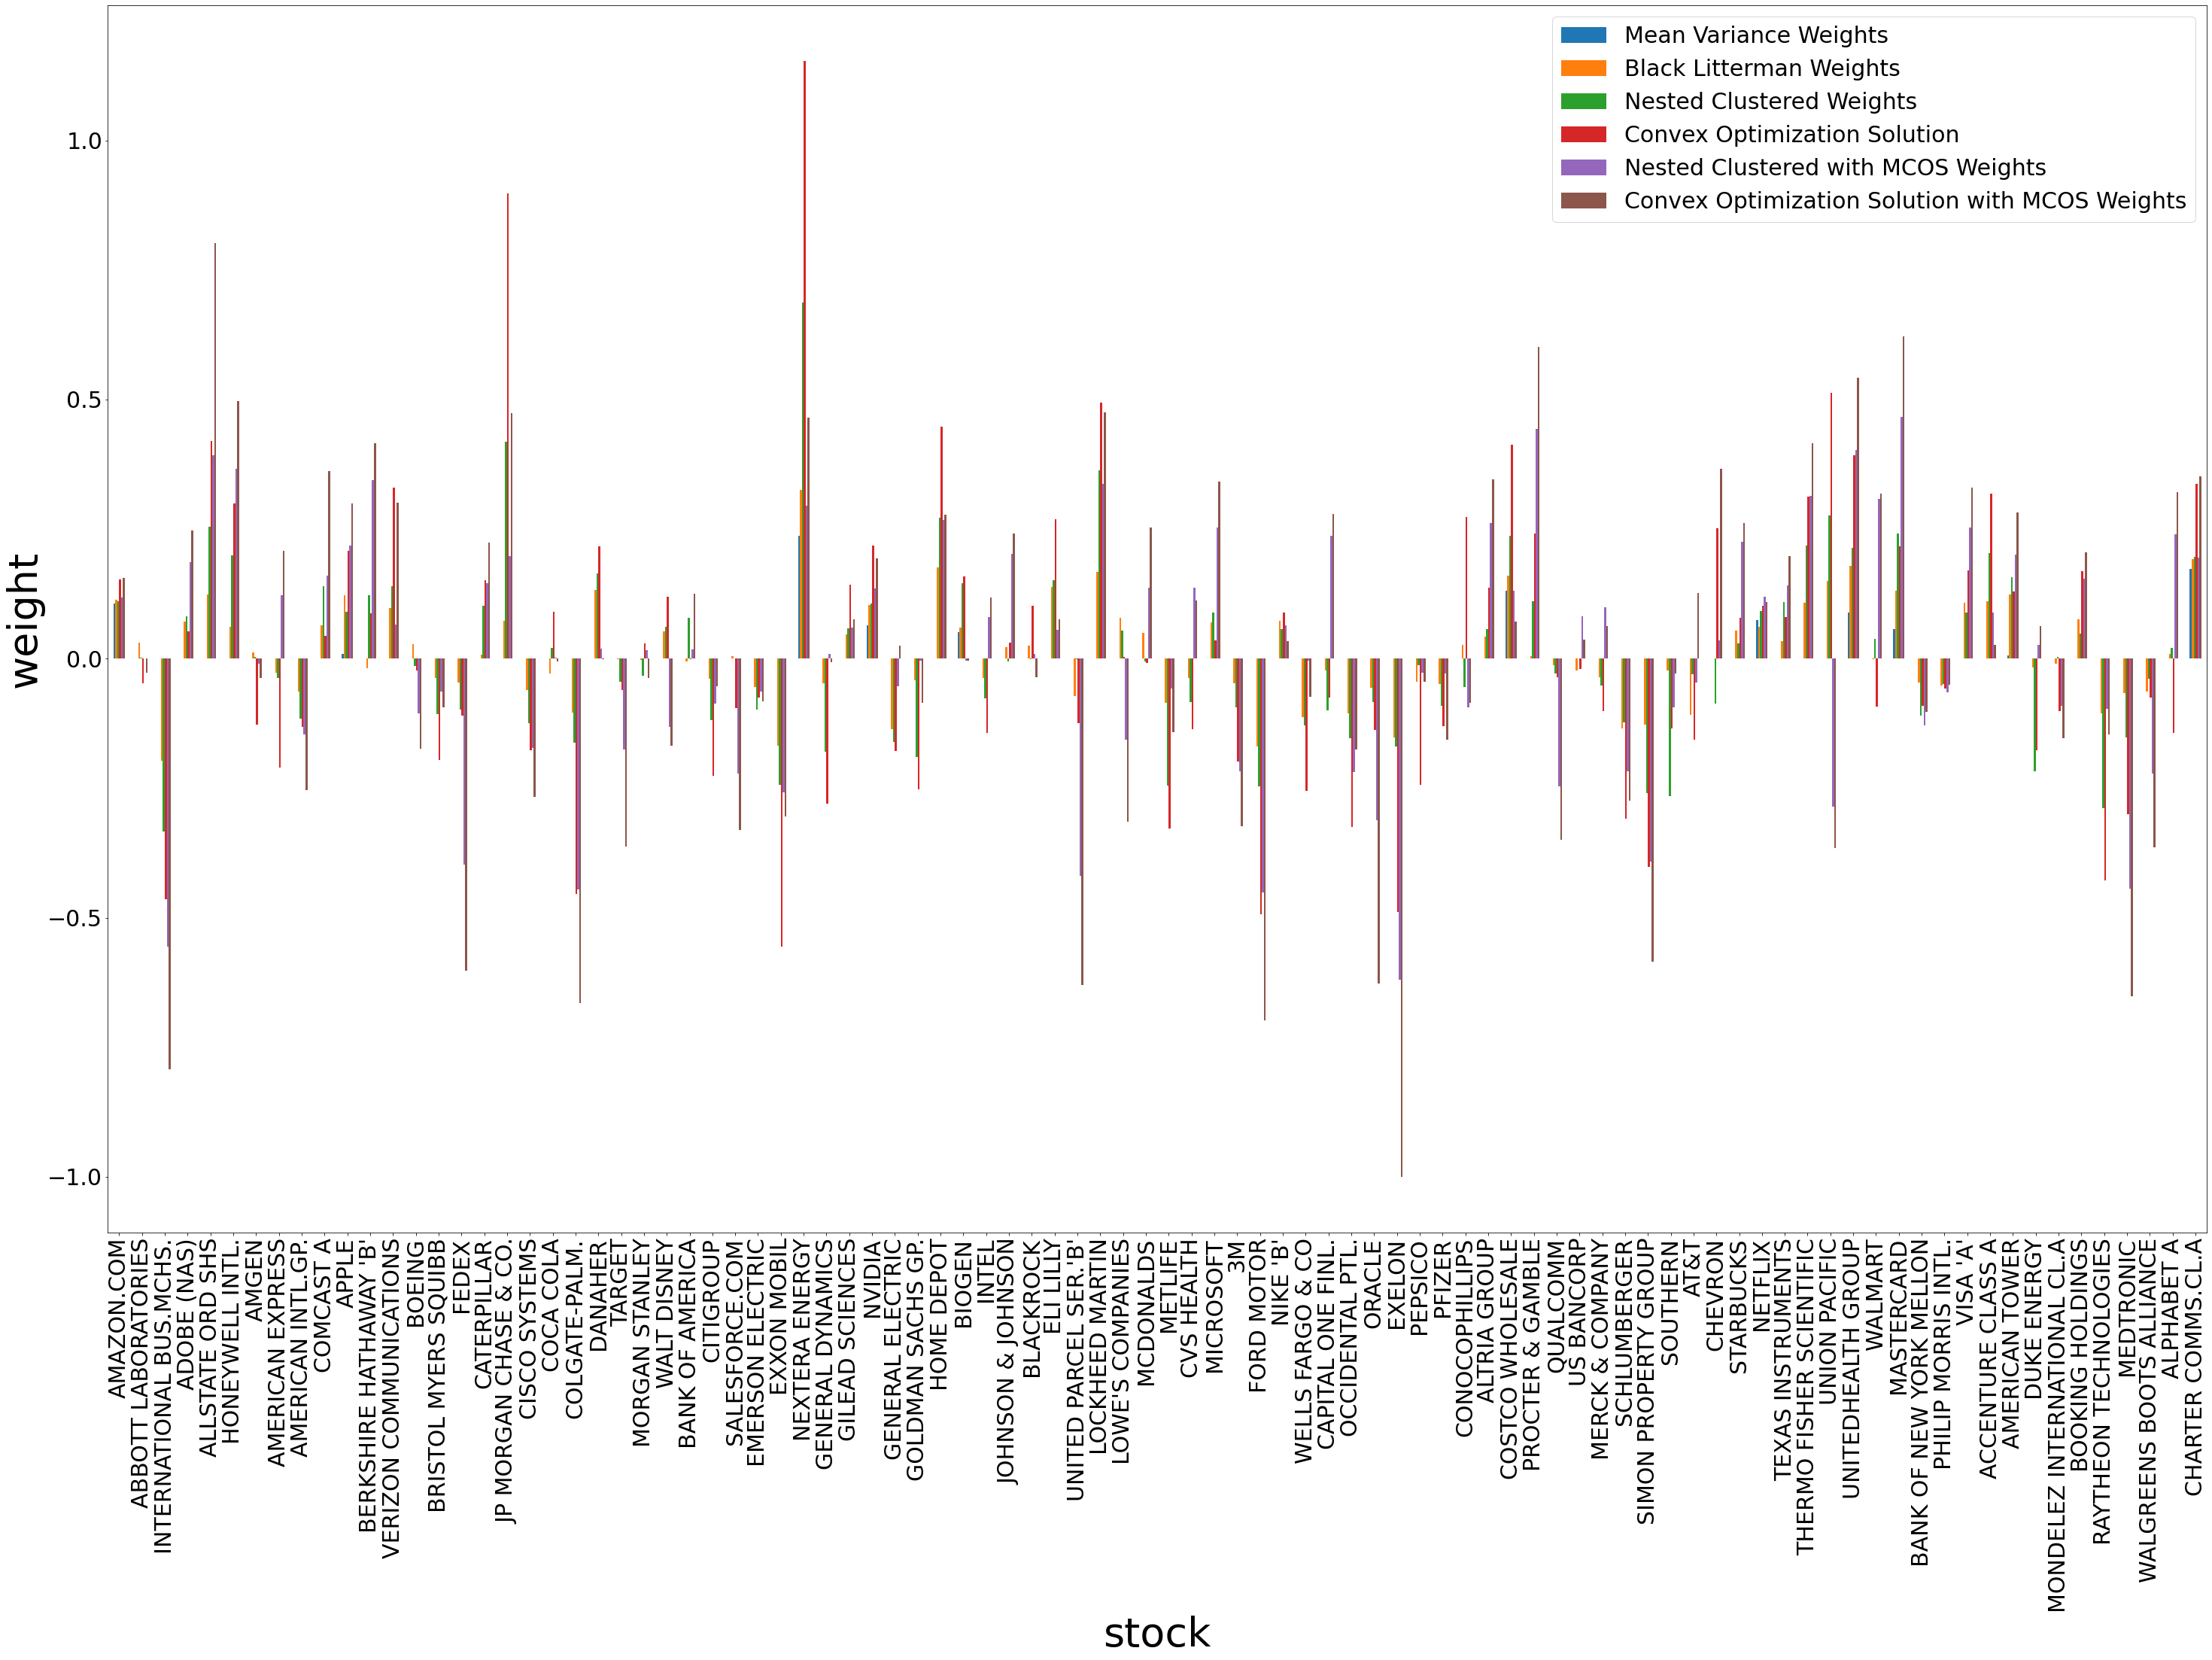

In [201]:
df = pd.DataFrame([EF.weights.reshape(92),np.array(list(bl.weights)).reshape(92),(w_nco/sum(w_nco)).reshape(92),\
                   (w_cvo/sum(w_cvo)).reshape(92),weight_nco_mcos,weight_cvo_mcos],
                  columns=data.columns,
                  index=['Mean Variance Weights','Black Litterman Weights','Nested Clustered Weights','Convex Optimization Solution',\
                         'Nested Clustered with MCOS Weights','Convex Optimization Solution with MCOS Weights'])
plot=df.T.plot(kind='bar',figsize=(50, 30),legend=True, fontsize=30)
plot.legend(loc=1,fontsize=30)
plot.set_xlabel('stock',fontdict={'fontsize':54})
plot.set_ylabel('weight',fontdict={'fontsize':54})

## (2) Analysis
## Weights have been newly calculated for the Black Litterman model as maximum return of portfolio compare to other portfolios of optimization.

## (3) Comparison of simulated portfolios average return and volatility

In [202]:
risk_free_3months=rate_free_simulation

In [203]:
df2 = pd.DataFrame([[Mean_variance_return,BL_return,NCO_return,CVO_return,\
                    nco_mcos_return,cvo_mcos_return],\
                    [Mean_variance_Volatility,\
                    Black_Litterman_volatility
                    ,NCO_volatility,CVO_volatility,nco_mcos_volatility,cvo_mcos_volatility],\
                    [(Mean_variance_return-risk_free_3months)/Mean_variance_Volatility,\
                     (BL_return-risk_free_3months)/Black_Litterman_volatility\
                     ,(NCO_return-risk_free_3months)/NCO_volatility,(CVO_return-risk_free_3months)/CVO_volatility,\
                    (nco_mcos_return-risk_free_3months)/nco_mcos_volatility,(cvo_mcos_return-risk_free_3months)/cvo_mcos_volatility\
                    ]],columns=["Mean Variance simulated value","Black Litterman simulated value",'Nested Clustered simulated value','Convex Optimization simulated value',\
                         'Nested Clustered with MCOS simulated value','Convex Optimization Solution with MCOS simulated value'],index=["Return","Volatility","Portfolio Sharpe Ratio"])
    
df2

,Mean Variance simulated value,Black Litterman simulated value,Nested Clustered simulated value,Convex Optimization simulated value,Nested Clustered with MCOS simulated value,Convex Optimization Solution with MCOS simulated value
Return,0.264408,0.692401,0.924273,1.330457,1.055849,1.333331
Volatility,0.172100,0.273859,0.373402,0.507939,0.509083,0.669140
Portfolio Sharpe Ratio,1.534614,2.527218,2.474473,2.618732,2.073433,1.992156


# 5, conclusion
## We are comparing 6 models, the mean variance model ,the Black Litterman model, Nested Clustered simulated value, Convex Optimization simulated value, Nested Clustered with MCOS simulated value and Convex Optimization Solution with MCOS simulated value from March 18, 2020 to June 16, 2020,We improved Black Litterman model as maximum return of portfolio compare to other portfolios of optimization.
## The average return of Black Litterman simulated value is  much higher than the annual return of Mean Variance expected value.
## Surprisingly the Convex Optimization Solution resulted in highest Return and Sharpe Ratioeven lager than the Black Litterman in maximum performance which weighted in real return.
## We find the convergence of Nested Clustered simulated value and Convex Optimization simulated value are stable as same values during several times of trainning.
## Compared to Nested Clustered optimizaion, Convex Optimization Solution is prefered to get a higer Return and Sharpe Ratio.
## Convex Optimization Solution with MCOS and Nested Clustered  with MCOS resulted are able to get as high return as NCO and CVO but unable to reach high performance as them because of its high Volatility.

# 6, reference list
##  translated by David G. Ruenberger, Hiroshi Konno, Kenichi Suzuki, Norio Bibiki, "Introduction to Financial Engineering: Second Edition," Nihon Keizai Shimbun (2015)
## Takahiro Komatsu “Optimal Investment Strategy” Asakura Shoten (2018)
## PyPortfolioOpt, https://pyportfolioopt.readthedocs.io/en/latest/
## Machine Learning Financial Laboratory (mlfinlab) https://mlfinlab.readthedocs.io/en/latest/index.html
## A ROBUST ESTIMATOR OF THE EFFICIENT FRONTIER https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961
## López de Prado Machine Learning for Asset Managers
## López de Prado Advances in Financial Machine Learning